# Clustering user queries using Fashion CLIP embeddings

### Introduction

We are attempting to gain insights on user queries.  We currently use a thrid-party model, Seneca, to make recommendations to users based on their queries and filters.  Seneca uses NER (Named Entity Recognition) to map queries+filters to named entities, via a LTSM recurrent netork.  Seneca has not been trained for at least five years and before we pay out the money to do so we want evaluate other options.  For example, the LTSM architecture is relatively outdated compared to Transformers, which may be more helpful in generating recommendations based off queries.

One quick exploration was looking at the SVD of the tf-idf matrix and using the "U" matrix as embeddings which I could then go on to cluster.  Clustering stats weren't great so here I'm inceasing the level of complexity and instead using the Fashion CLIP model to encode the queries.

## Step 1: Investigate clusters, via Fashion CLIP embeddings of queries

In [2]:
# !pip install --no-binary snowflake-connector-python --force-reinstall "https://github.com/iserko/snowflake-connector-python/archive/refs/heads/SNOW-XXXXXX_wait_for_url_input_after_sso.zip#egg=snowflake-connector-python[secure-local-storage]" -q
# !pip install --user annoy
# !pip install transformers
import os
import pandas as pd
import snowflake.connector
import traceback
import matplotlib.pyplot as plt
import pickle
import numpy as np
import ast
import torch
import requests
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import sklearn as sk
from pathlib import Path
from io import BytesIO
from transformers import AutoProcessor, AutoModel, AutoTokenizer, CLIPTextModelWithProjection 
from typing import Callable, Dict, Iterator
# from PIL import Image
# from annoy import AnnoyIndex
# from torchvision import transforms

import pydqt
# set workspace
pydqt.set_workspace('/Users/mingham/research/workspaces/','search_and_recs')

# import local embeddings code
import sys
sys.path.append('../src/')
import embeddings


/Users/mingham/research/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Fashion CLIP Model from Hugging Face

Fashion CLIP is a transformer based model which is a fine-tuning of the more general CLIP model and both of them are available on Hugging Face.

In [2]:
# # this is the more general CLIP model - ie not fine-tuned for fashion
# model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
# tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
# queries_data = ["a photo of a cat", "a photo of a dog"]

# this is the fashion version
model_name = "patrickjohncyh/fashion-clip"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def get_embeddings(list_of_queries=[]):
    inputs = tokenizer(list_of_queries, padding=True, return_tensors="pt")
    embeddings = model.get_text_features(**inputs).detach().cpu().numpy()
    return embeddings

### Get queries from Snowflake

In [12]:
df = pd.read_csv('/Users/mingham/research/workspaces/search_and_recs/cache/series_queries_with_session_id.csv')

In [13]:
df['QUERY']

0         alexander mcqueen women sneakers
1                       michael kors women
2                           basketball men
3                            airmax 90 men
4                             feragamo men
                        ...               
677257                  givenchy men shoes
677258                         gucci women
677259                  snekars velvet men
677260                  balmain women bags
677261                   fendi women shoes
Name: QUERY, Length: 677262, dtype: object

In [10]:
# q=pydqt.Query('queries.sql',min_query_date='2023-08-01',max_query_date='2023-08-15')
q=pydqt.Query('queries.sql',min_query_date='2024-02-01',max_query_date='2024-02-05')
q.load()
q.df['QUERY']=q.df['SEARCH_QUERY'].apply(lambda x: ' '.join(eval(x)))
# print(q.df.head())
search_queries_with_view_id = q.df[['VIEW_ID','QUERY']]
search_queries_with_view_id=search_queries_with_view_id.dropna(how='any')
search_queries_with_view_id.to_csv('/Users/mingham/research/workspaces/search_and_recs/cache/series_queries_with_view_id.csv')


# search_queries = q.df['SEARCH_QUERY'].apply(lambda x: ' '.join(eval(x)))
# search_queries=search_queries.dropna(how='any')
# search_queries.to_csv('/Users/mingham/research/workspaces/search_and_recs/cache/series_queries.csv')


In [11]:
search_queries_with_session_id

,SESSION_ID,QUERY
0,952ef0bf-8541-4cd4-92cc-e44d520a536d,alexander mcqueen women sneakers
1,e694d04f-e744-4c53-beb4-8371f38bc670,michael kors women
2,283fb6a5-ca9b-4ad6-a8fd-be0413ef09bb,basketball men
3,a35cad5f-3d1b-4092-ab58-9247392c2dc9,airmax 90 men
4,e5e8747a-f917-4a23-8962-5a9a5e93064d,feragamo men
...,...,...
677257,3aa02958-c130-4677-97ea-df672eb32a50,givenchy men shoes
677258,a58bee58-c1e6-4fa3-a18e-d1a1a82dc0f9,gucci women
677259,25bf30d1-4a4e-46f4-a5db-620f686d8a86,snekars velvet men
677260,b307bb71-f7b3-4133-a688-98ea32d0ba23,balmain women bags


In [7]:
search_queries

0         alexander mcqueen women sneakers
1                       michael kors women
2                           basketball men
3                            airmax 90 men
4                             feragamo men
                        ...               
677258                         gucci women
677259                  snekars velvet men
677260                  balmain women bags
677261                   fendi women shoes
a                                       yo
Name: SEARCH_QUERY, Length: 677263, dtype: object

### Calculate embeddings of queries using the Fashion CLIP model
##### Can't do too many queries at once - you run out of memory on local!!

In [ ]:
query_embeddings = get_embeddings(search_queries['SEARCH_QUERY'].to_list())

: 

Calculating the embeddings of 2 weeks' worth of search queries (c.6m), results in a peak memory usage of 45.1GB before crashing (my mac only has 16GB RAM).  The activation function alone needs 17GB of memory allocation.

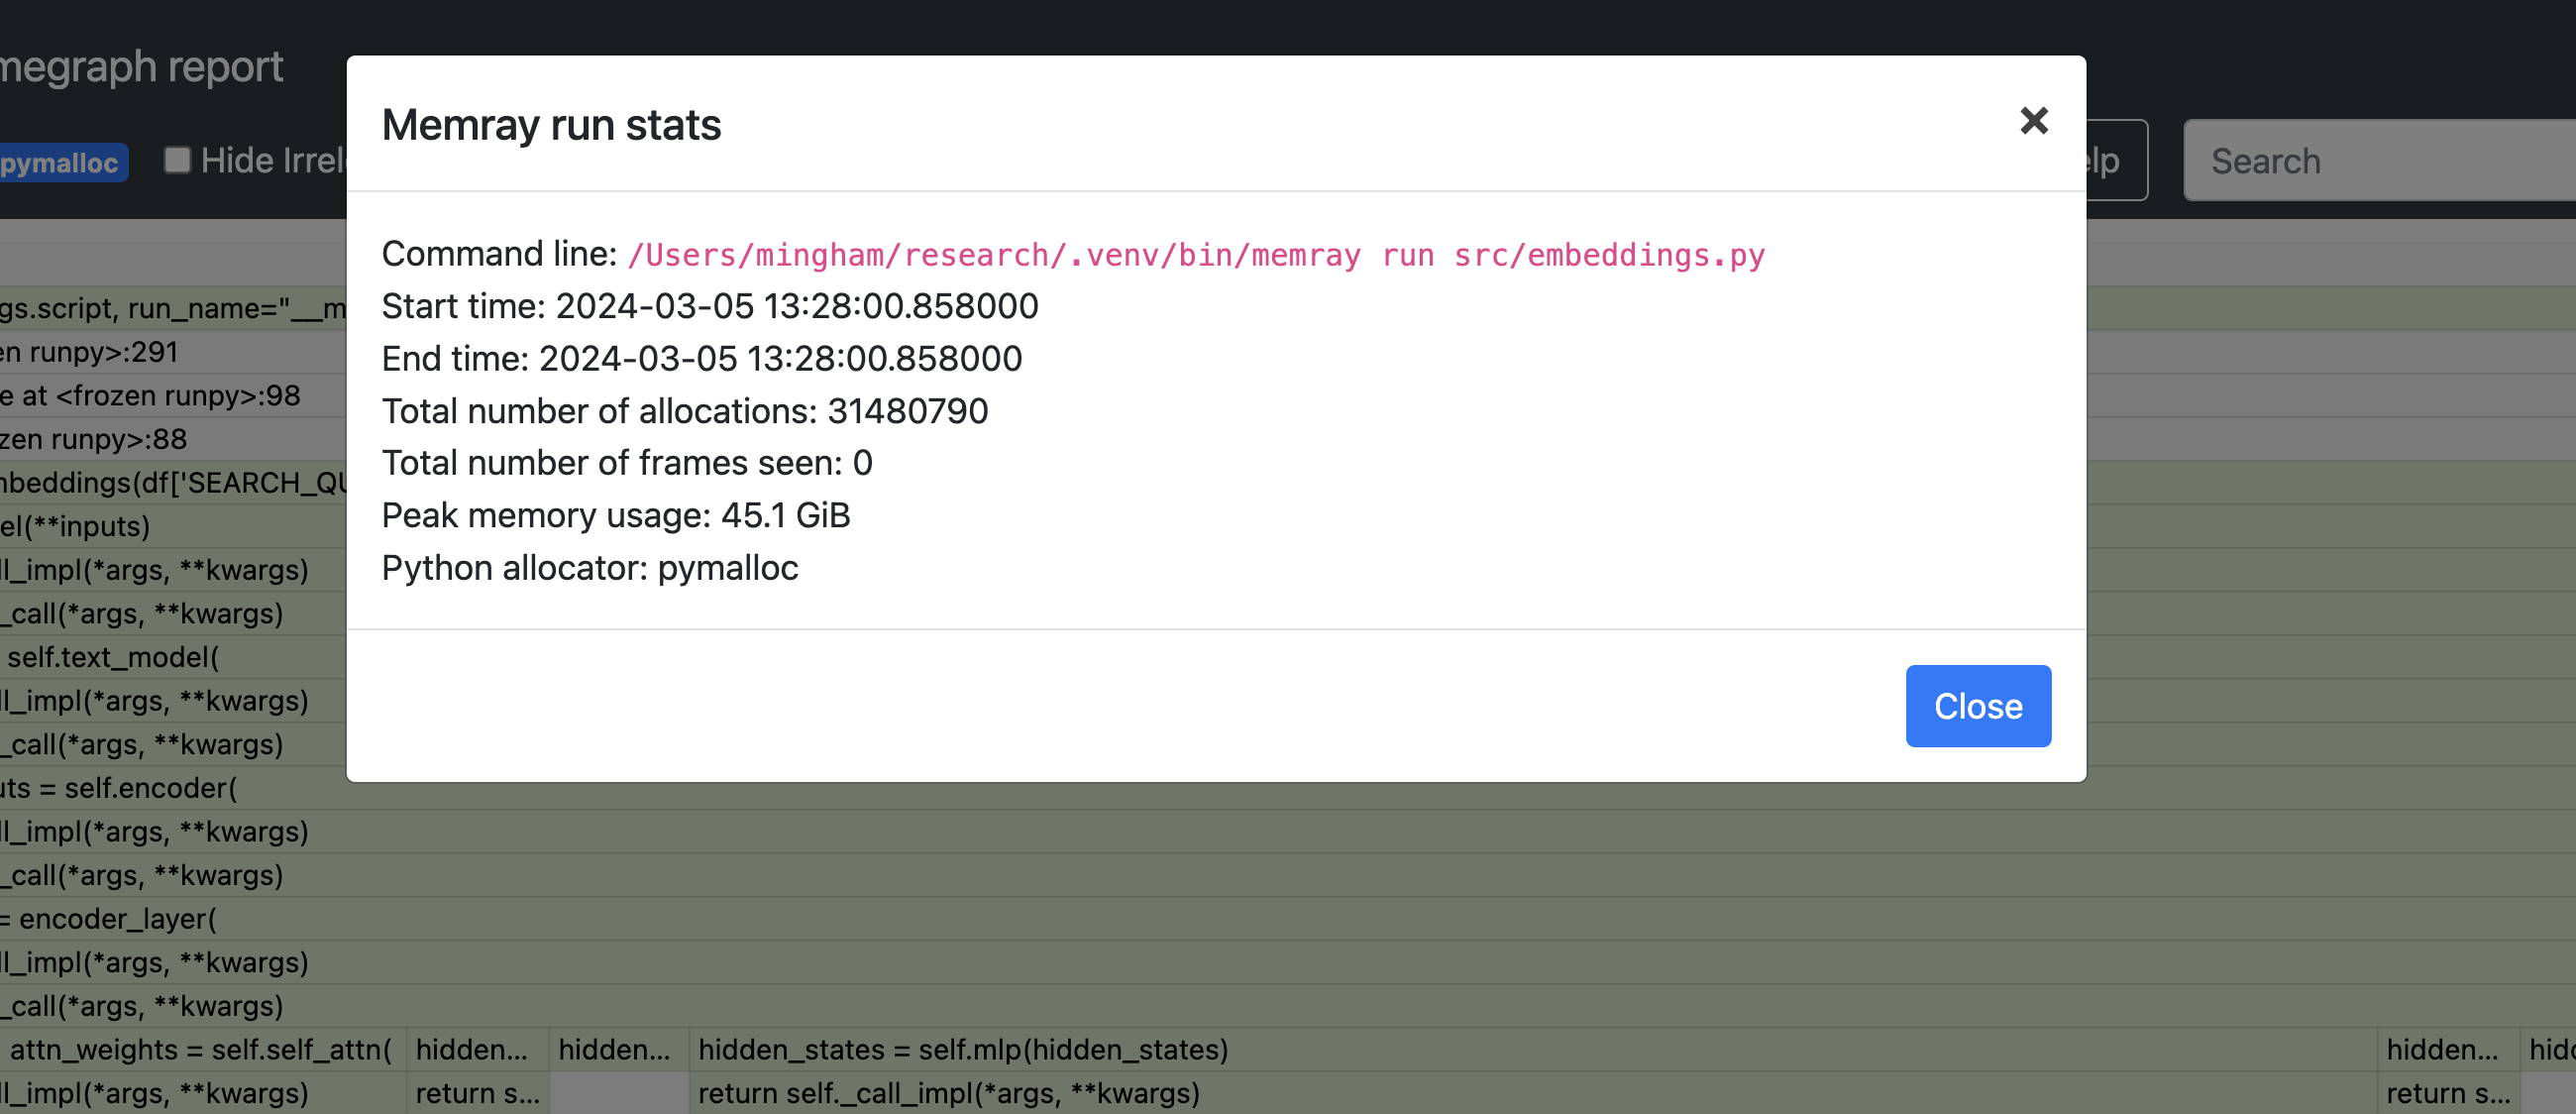

Splitting the 2 weeks of data into chunks of 10,000 queries seems to be near the sweet spot.

src/embeddings.py is a script that will automatically grab the queries and compute their embeddings in desired chunk sizes and number of runs

```
python /Users/mingham/research/src/embeddings.py --number_of_runs=50 --chunk_size=200 --epochs=5
```

## Let's investigate the embeddings

### Step 1: kmeans clustering

In [6]:
embeddings_df = pd.read_csv('../src/embeddings_0.csv')

In [7]:
embeddings_df

,query,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,arcteryx,-0.395560,-0.262860,-0.284100,0.011488,0.076927,0.110884,-0.285859,-0.326531,0.206412,...,-0.090949,-0.385271,0.618263,0.254585,-0.120005,0.444667,-0.412261,0.316306,0.152145,0.313028
1,maxi dresses,0.143916,0.229968,-0.115475,-0.314809,-0.458020,-0.212207,0.135059,-0.199067,-0.210132,...,-0.515929,0.213758,-0.092813,0.306110,-0.547499,0.096689,0.120332,-0.086583,-0.293282,-0.027134
2,ombre,-0.042962,-0.105800,-0.312130,-0.075232,0.104917,-0.682406,0.211086,0.011595,-0.509873,...,0.490269,0.496583,0.007607,0.167649,0.256382,-0.256495,-0.144386,0.114731,-0.054913,-0.113850
3,leather men watches,-0.199659,-0.196586,-0.317964,-0.056889,-0.154712,0.193010,-0.540888,0.230961,0.236104,...,0.241771,0.019140,0.169263,0.186371,-0.234857,-0.209304,-0.567151,0.335694,0.112867,0.039943
4,veja sneakers,-0.665682,0.027221,0.017952,0.090470,0.412678,0.116795,0.288420,0.510706,-0.261173,...,0.203052,-0.389767,-0.063641,0.221538,0.120219,0.321691,0.118836,0.817288,0.120002,0.386504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,gucci sunglasses man men sunglasses,-0.069499,-0.178276,-0.364105,0.426969,0.267143,-0.290689,-0.000035,-0.055167,0.051008,...,0.329012,-0.282919,-0.073627,0.155520,0.242745,0.507153,-0.033691,0.327406,0.048072,0.426959
9796,adidas campus women sneakers shoes,-0.223716,-0.167532,0.225512,0.047612,0.103533,-0.321556,-0.246503,0.331763,-0.064343,...,0.317382,-0.126430,-0.010789,0.008653,0.397690,0.265546,-0.342552,0.471020,-0.201314,0.219704
9797,adidas campus women,-0.040021,-0.172015,0.192343,-0.018888,-0.031713,-0.303292,-0.269734,0.195173,-0.140023,...,0.287538,-0.090998,0.056182,0.011296,0.328406,0.265950,-0.304207,0.550052,-0.264351,0.275440
9798,sweater men,-0.189443,-0.129660,-0.571684,0.249088,0.131924,-0.470789,-0.082491,-0.331884,-0.233539,...,0.260300,-0.187784,0.202512,0.241303,0.326814,0.273237,0.072943,0.162269,-0.007796,-0.215523


Prep the data

In [8]:
def ortho(X):
    # create orthornmal embeddings
    length = np.sqrt((X**2).sum(axis=1))[:,None]
    return X / length

def create_ortho_embeddings(embeddings_df):
    xx = embeddings_df.drop_duplicates(['query'])
    xx = xx.reset_index(drop=True)
    
    embeddings2 = ortho(xx[xx.columns[1:]].to_numpy())
    column_names = [f'feature_{i}' for i in range(1, embeddings2.shape[1] + 1)]
    embeddings2_df = pd.DataFrame(data=embeddings2,columns=column_names)
    # df_nodups = embeddings2_df.drop_duplicates(['query'])
    # df_nodups = df_nodups.reset_index(drop=True)
    embeddings2_df['query']=xx['query']
    df_nodups = embeddings2_df[['query']+column_names]
    return embeddings2_df, column_names


In [9]:
embeddings2_df, column_names = create_ortho_embeddings(embeddings_df)


In [10]:
column_names

['feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_66',
 'feature_67',
 'fe

Do the KMeans (using sklearn with unit embeddings, i.e. embeddings_df2)

In [12]:
def compute_clusters(df,column_names):
    clusterer = KMeans(n_clusters=10, random_state=10)
    cluster_labels = clusterer.fit_predict(df[column_names].to_numpy())
    return cluster_labels
ortho_embeddings_df, column_names = create_ortho_embeddings(embeddings_df)
cluster_labels = compute_clusters(ortho_embeddings_df, column_names)

# create dict with cluster_labels as key and array of queries as values
cluster_indices = [x for x in range(0,10)]
cluster_dict = {}
def get_indices(x,n):
    i=[]
    for idx, val in enumerate(x):
        if val==n:
            i.append(idx)
    return i
for cluster_idx in cluster_indices:    
    cluster_dict[cluster_idx] = embeddings2_df.iloc[get_indices(cluster_labels, cluster_idx)]['query']
    # cluster_dict[cluster_idx] = []

#### First cluster (note first cluster doesn't necessarily mean, "most important")

In [13]:
cluster_dict[0]

5                   dolce gabanna women dresses
16              gucci brixton women flats shoes
18      saint laurent star women sneakers shoes
28                               max mara coats
33                            gucci women shoes
                         ...                   
6146                       karl lagerfeld women
6147                          reiss nina skirts
6162                   dior slingback ballerina
6167                         rixo women dresses
6172                ralph lauren sudadera women
Name: query, Length: 681, dtype: object

#### Last cluster

In [14]:
cluster_dict[9]

99                       lentes prada women
154                 tom ford men sunglasses
276                 miumiu women sunglasses
350                  loewe women sunglasses
434                        prada sunglasses
                       ...                 
5932       gucci polarized women sunglasses
5971      oval women sunglasses accessories
6021        balmsin wooman women sunglasses
6054                burberry men sunglasses
6179    gucci sunglasses man men sunglasses
Name: query, Length: 119, dtype: object

#### Some KMeans stats - the silouehtte coefficient

In [15]:
def plot_single_page(start_idx,df,column_names,sup=False):
    range_n_clusters = [2, 5,7,8,9,10,11,12, 15, 20, 30, 40,80,100,200,400, 600, 800, 1600, 2400]
    X=df[column_names].to_numpy()
    fig, axes = plt.subplots(2, 2)
    # print(axes[0])
    fig.set_size_inches(18, 7)
    axes_2 = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
    inertia = []
    for idx,ax in enumerate(axes_2):
        n_clusters = range_n_clusters[start_idx+idx]
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        errors = clusterer.inertia_
        inertia.append(errors)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed

        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters+1):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title(f"N clusters = {i}")
        if idx in [2,3]:
            ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    if sup:
        plt.suptitle("Silhouette analysis for KMeans clustering on Fashion CLIP embeddings of queries",                
            fontsize=14,
            fontweight="bold",
        )

    return inertia    
        

In [20]:
def create_cluster_report(indf):
    range_n_clusters = [2, 5,7,8,9,10,11,12, 15, 20, 30, 40,80,100,200,400, 600, 800, 1600, 2400]
    df, column_names = create_ortho_embeddings(indf)
    df=df.dropna()
    if df.shape[0]>0:
        df = df.reset_index(drop=True)

        # X=df[column_names].to_numpy()
        inertias = []
        for page in range(0,5):
            # Create a subplot with 2 rows and 2 columns
            sup=False
            if page==0:
                sup=True        
            errors = plot_single_page(page*4,df,column_names,sup)
            inertias = inertias + errors
        plt.show()
        return inertias

Let's look at the gradient of cluster inertia (total sum of all within cluster SSEs, ie kmeans' objective function) versus N

In [21]:

def plot_inertia(inertias):
    range_n_clusters = [2, 5,7,8,9,10,11,12, 15, 20, 30, 40,80,100,200,400, 600, 800, 1600, 2400]
    plt.plot(range_n_clusters, inertias, marker='o');
    plt.xlabel('Number of clusters');
    plt.ylabel('Inertia');

For n_clusters = 2 The average silhouette_score is : 0.06697686730332002
For n_clusters = 5 The average silhouette_score is : 0.019135240546097856
For n_clusters = 7 The average silhouette_score is : 0.0389245677458382
For n_clusters = 8 The average silhouette_score is : 0.03978256409629902
For n_clusters = 9 The average silhouette_score is : 0.043224218362951615
For n_clusters = 10 The average silhouette_score is : 0.043348806886581534
For n_clusters = 11 The average silhouette_score is : 0.05292090209826399
For n_clusters = 12 The average silhouette_score is : 0.055427899785729255
For n_clusters = 15 The average silhouette_score is : 0.0574944403968919
For n_clusters = 20 The average silhouette_score is : 0.05414095447750094
For n_clusters = 30 The average silhouette_score is : 0.056458091762172855
For n_clusters = 40 The average silhouette_score is : 0.06359226339325998
For n_clusters = 80 The average silhouette_score is : 0.06937978650700795
For n_clusters = 100 The average silhoue

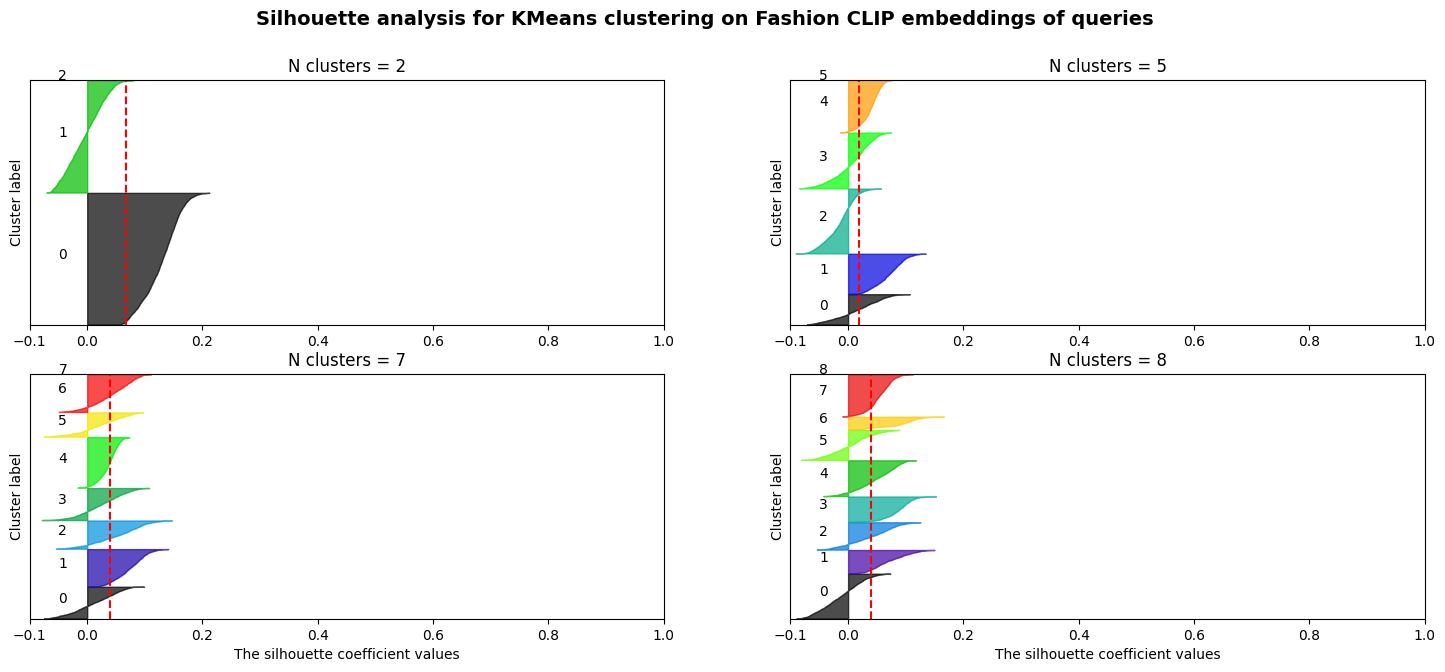

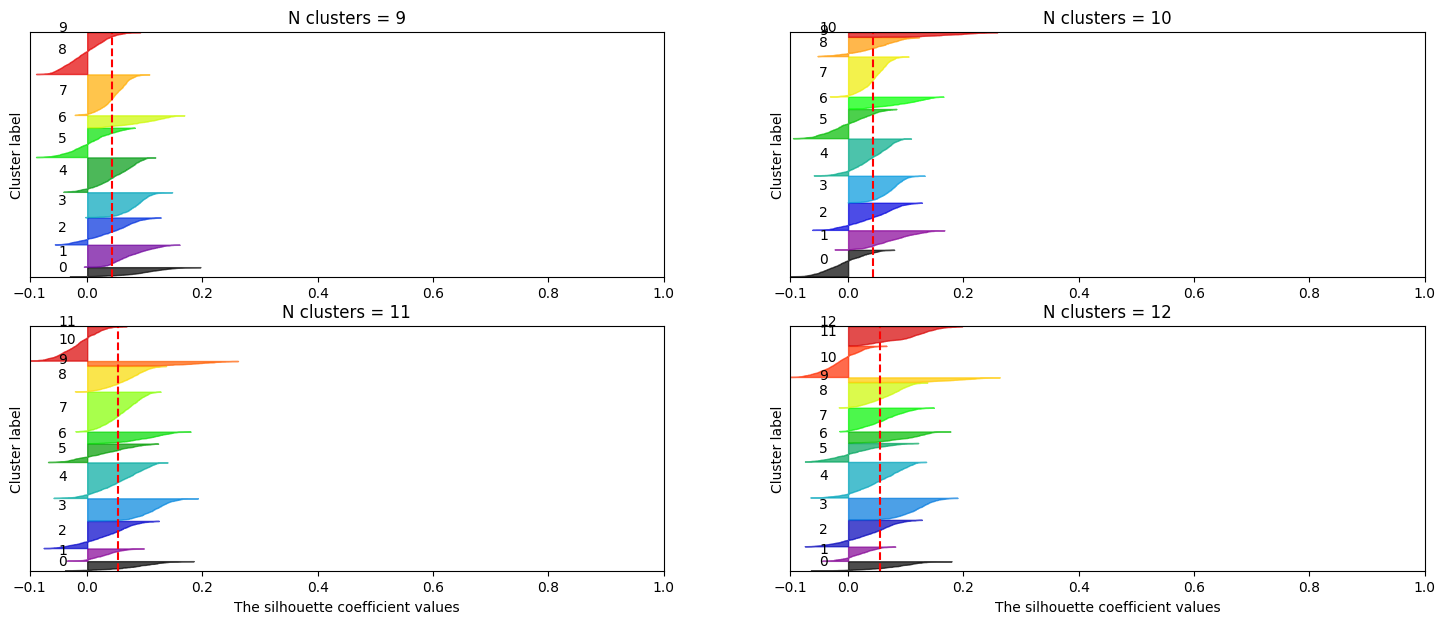

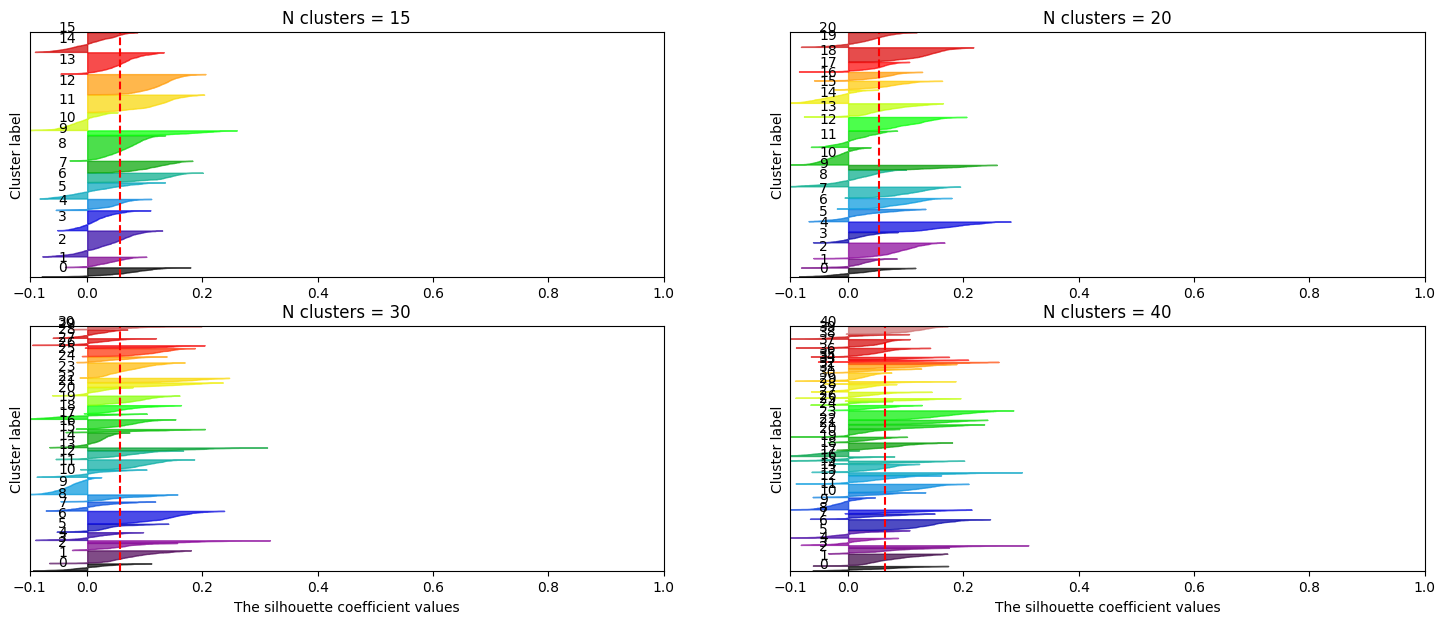

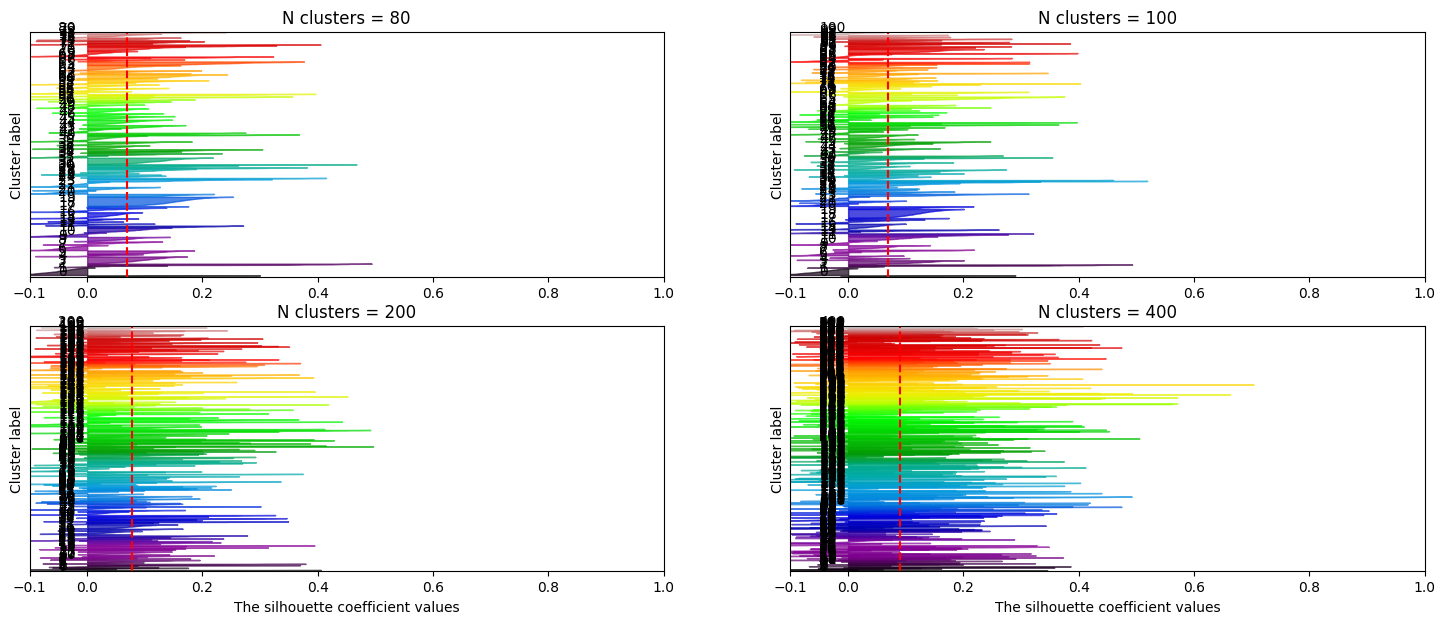

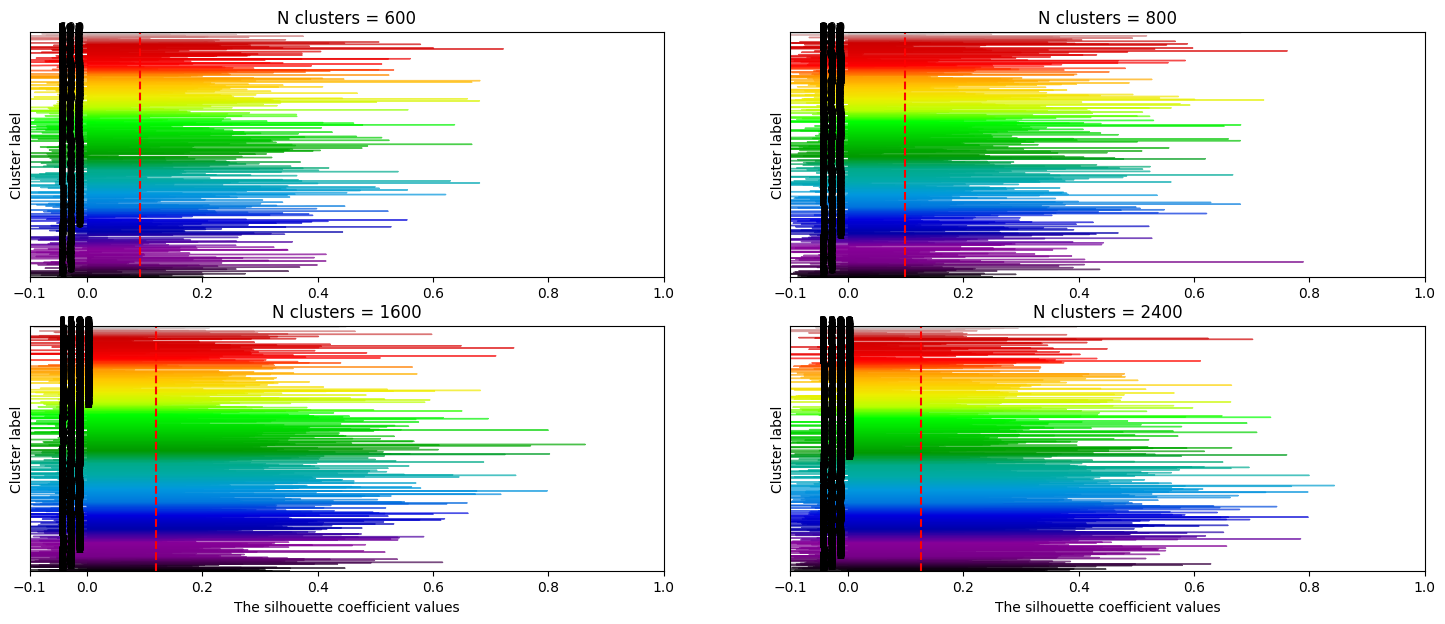

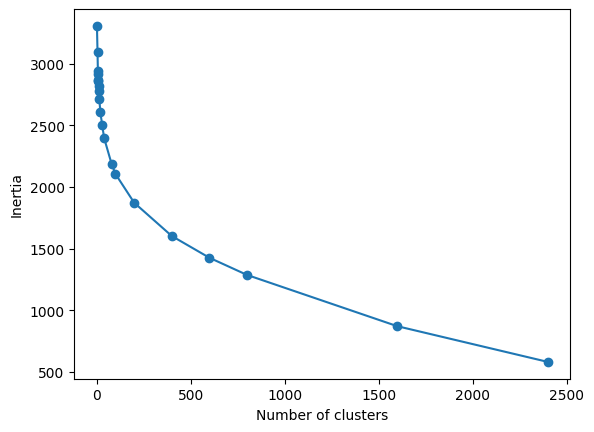

In [22]:
plot_inertia(create_cluster_report(embeddings_df))

### Summary
##### Inertia is still declining significantly after 1000 clusters, however we can see from the silhouette plots that there must be many singleton clusters (silhouette==1 => singleton)

##### All the above was done on a sample of c.10K - let's increase sample size to see if we can improve quality of kmeans


In [ ]:
### Load some embeddings
csv_files = ['/Users/mingham/research/src/' + x for x in os.listdir('/Users/mingham/research/src/') if x[-4:] == '.csv']
import random
import math

def get_random_samples(sample_size = 100000):
    n_files = min(math.floor(sample_size/10000),len(csv_files))
    chosen_files = random.sample(csv_files, n_files)
    for (idx, fn) in enumerate(chosen_files):
        if idx==0:
            df = pd.read_csv(fn)
        else:
            df = pd.concat([df, pd.read_csv(fn)],axis=0)    
    return df

# def run_kmeans(sample_size = 100000):
#     # approx 10k in each csv
    
# embeddings_df = pd.read_csv('../src/embeddings_0.csv')
# embeddings2_df, column_names = create_ortho_embeddings(embeddings_df)

xx=get_random_samples()
xx.shape

(93393, 513)

In [ ]:
n_samples=1000000
df=get_random_samples(n_samples)
# embeddings2_df, column_names = create_ortho_embeddings(get_random_samples(n_samples))

embeddings



<module 'embeddings' from '/Users/mingham/research/notebooks/../src/embeddings.py'>

ValueError: x, y, and format string must not be None

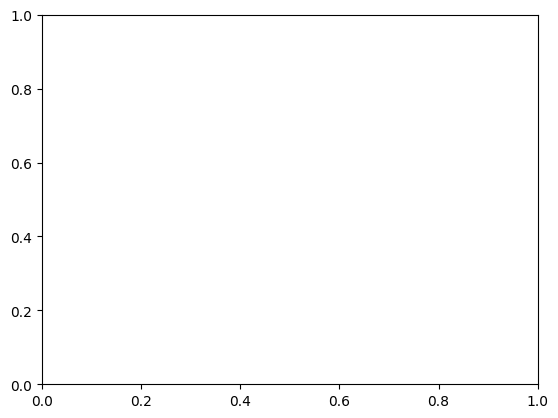

In [ ]:
# df[df.duplicated(['query'])]
# df[df['query']=="socks men"]
df_nodups = df.drop_duplicates(subset=['query'])

inertias = create_cluster_report(df_nodups)
plot_inertia(inertias)

In [ ]:
xx=df_nodups.reset_index(drop=True)


In [ ]:
xx

,query,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512,last_epoch,chunk_size,number_of_runs
0,dolce & gabbana brown leather brass logo buckl...,-0.437736,-0.123936,0.315314,0.060930,0.103432,-0.134816,-0.406356,-0.117303,0.071989,...,0.086779,0.284513,0.143513,0.019701,0.264880,0.064950,0.043859,NaN,NaN,NaN
1,tote women bags,0.019384,-0.007427,0.206003,-0.243785,-0.116460,-0.295539,0.311753,0.147804,-0.194849,...,0.022336,-0.228279,0.630911,-0.393950,-0.021491,0.007858,0.626824,NaN,NaN,NaN
2,with puffy sleeves women tops,-0.236289,0.138688,-0.130673,-0.194752,0.372122,-0.179316,-0.199423,-0.185689,0.220351,...,0.135096,0.075096,0.571975,0.188716,0.023264,-0.082327,-0.177881,NaN,NaN,NaN
3,striped men pants clothing,0.173577,-0.175145,-0.325401,0.081918,-0.065179,-0.192347,-0.128414,0.129430,-0.086755,...,0.247888,0.076647,0.564899,-0.078663,-0.095420,-0.079532,0.233310,NaN,NaN,NaN
4,puffer women jackets,-0.231655,-0.109286,0.102941,0.166988,0.144904,-0.451544,0.018735,-0.043074,0.260594,...,-0.095891,0.024368,0.171041,-0.347845,-0.254606,0.099283,0.155387,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51778,butterfly frame fendi sunglasses,0.189676,0.058019,0.131094,0.246475,0.624648,-0.276937,-0.253207,0.117230,-0.378178,...,0.028280,0.031480,0.364522,-0.079520,0.403701,0.056054,0.334000,NaN,NaN,NaN
51779,16arlington women,-0.074760,-0.209853,0.049617,0.022318,0.209422,-0.019704,-0.213176,-0.331291,-0.200502,...,-0.016018,-0.382565,0.302705,-0.166624,0.309523,-0.072388,-0.130713,NaN,NaN,NaN
51780,t bar flat sandals women,-0.039465,0.093009,0.230311,0.040359,0.088266,0.205858,0.076330,-0.117155,-0.057114,...,0.270740,-0.287508,0.186250,0.151198,0.061105,-0.087193,-0.261032,NaN,NaN,NaN
51781,ray ban women sunglasses,0.048019,-0.065034,0.121939,0.262233,0.268104,-0.272913,-0.193797,0.355489,-0.109020,...,-0.076921,-0.012838,0.729152,-0.085733,0.365562,-0.018943,0.285550,NaN,NaN,NaN


In [ ]:
df_nodups

,query,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512,last_epoch,chunk_size,number_of_runs
0,dolce & gabbana brown leather brass logo buckl...,-0.437736,-0.123936,0.315314,0.060930,0.103432,-0.134816,-0.406356,-0.117303,0.071989,...,0.086779,0.284513,0.143513,0.019701,0.264880,0.064950,0.043859,NaN,NaN,NaN
1,tote women bags,0.019384,-0.007427,0.206003,-0.243785,-0.116460,-0.295539,0.311753,0.147804,-0.194849,...,0.022336,-0.228279,0.630911,-0.393950,-0.021491,0.007858,0.626824,NaN,NaN,NaN
2,with puffy sleeves women tops,-0.236289,0.138688,-0.130673,-0.194752,0.372122,-0.179316,-0.199423,-0.185689,0.220351,...,0.135096,0.075096,0.571975,0.188716,0.023264,-0.082327,-0.177881,NaN,NaN,NaN
3,striped men pants clothing,0.173577,-0.175145,-0.325401,0.081918,-0.065179,-0.192347,-0.128414,0.129430,-0.086755,...,0.247888,0.076647,0.564899,-0.078663,-0.095420,-0.079532,0.233310,NaN,NaN,NaN
4,puffer women jackets,-0.231655,-0.109286,0.102941,0.166988,0.144904,-0.451544,0.018735,-0.043074,0.260594,...,-0.095891,0.024368,0.171041,-0.347845,-0.254606,0.099283,0.155387,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5165,butterfly frame fendi sunglasses,0.189676,0.058019,0.131094,0.246475,0.624648,-0.276937,-0.253207,0.117230,-0.378178,...,0.028280,0.031480,0.364522,-0.079520,0.403701,0.056054,0.334000,NaN,NaN,NaN
5166,16arlington women,-0.074760,-0.209853,0.049617,0.022318,0.209422,-0.019704,-0.213176,-0.331291,-0.200502,...,-0.016018,-0.382565,0.302705,-0.166624,0.309523,-0.072388,-0.130713,NaN,NaN,NaN
5175,t bar flat sandals women,-0.039465,0.093009,0.230311,0.040359,0.088266,0.205858,0.076330,-0.117155,-0.057114,...,0.270740,-0.287508,0.186250,0.151198,0.061105,-0.087193,-0.261032,NaN,NaN,NaN
5192,ray ban women sunglasses,0.048019,-0.065034,0.121939,0.262233,0.268104,-0.272913,-0.193797,0.355489,-0.109020,...,-0.076921,-0.012838,0.729152,-0.085733,0.365562,-0.018943,0.285550,NaN,NaN,NaN


In [ ]:
df_nodups.to_parquet()

##### Let's try a more simple approach to deriving embeddings of queries

### SVD of the tf amd tf-idf matrices.  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 

# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True) 

# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(embeddings2_df['query'])

In [ ]:
second_vector_tfidfvectorizer=tfidf_vectorizer_vectors[1] 

# place tf-idf values in a pandas data frame 
df_tfidf = pd.DataFrame(second_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"]).sort_values(by=["tfidf"],ascending=False)
df_tfidf


,tfidf
maxi,0.859362
dresses,0.511367
00,0.000000
pepper,0.000000
peasant,0.000000
...,...
fendi,0.000000
ferragamo,0.000000
ferragni,0.000000
ferrari,0.000000


,tfidf
maxi,0.859362
dresses,0.511367
00,0.000000
pepper,0.000000
peasant,0.000000
...,...
fendi,0.000000
ferragamo,0.000000
ferragni,0.000000
ferrari,0.000000


In [ ]:
embeddings2_df

,query,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,arcteryx,-0.054570,-0.036263,-0.039193,0.001585,0.010613,0.015297,-0.039436,-0.045047,0.028476,...,-0.012547,-0.053151,0.085293,0.035122,-0.016555,0.061345,-0.056874,0.043636,0.020989,0.043184
1,maxi dresses,0.016469,0.026316,-0.013214,-0.036025,-0.052413,-0.024284,0.015455,-0.022780,-0.024046,...,-0.059040,0.024461,-0.010621,0.035030,-0.062653,0.011065,0.013770,-0.009908,-0.033562,-0.003105
2,ombre,-0.005037,-0.012404,-0.036593,-0.008820,0.012300,-0.080003,0.024747,0.001359,-0.059776,...,0.057477,0.058218,0.000892,0.019655,0.030057,-0.030071,-0.016927,0.013451,-0.006438,-0.013347
3,leather men watches,-0.021682,-0.021348,-0.034529,-0.006178,-0.016801,0.020960,-0.058738,0.025081,0.025640,...,0.026255,0.002078,0.018381,0.020239,-0.025504,-0.022729,-0.061590,0.036455,0.012257,0.004338
4,veja sneakers,-0.095910,0.003922,0.002586,0.013035,0.059458,0.016828,0.041555,0.073582,-0.037629,...,0.029255,-0.056157,-0.009169,0.031919,0.017321,0.046349,0.017122,0.117753,0.017290,0.055687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,gucci sunglasses man men sunglasses,-0.009399,-0.024110,-0.049241,0.057743,0.036128,-0.039312,-0.000005,-0.007461,0.006898,...,0.044495,-0.038262,-0.009957,0.021032,0.032829,0.068587,-0.004556,0.044278,0.006501,0.057742
9796,adidas campus women sneakers shoes,-0.030866,-0.023115,0.031114,0.006569,0.014285,-0.044366,-0.034010,0.045774,-0.008878,...,0.043790,-0.017444,-0.001489,0.001194,0.054870,0.036638,-0.047262,0.064987,-0.027776,0.030313
9797,adidas campus women,-0.005622,-0.024163,0.027018,-0.002653,-0.004455,-0.042603,-0.037889,0.027416,-0.019669,...,0.040390,-0.012782,0.007892,0.001587,0.046131,0.037358,-0.042732,0.077265,-0.037133,0.038691
9798,sweater men,-0.022502,-0.015401,-0.067904,0.029586,0.015670,-0.055919,-0.009798,-0.039421,-0.027739,...,0.030918,-0.022305,0.024054,0.028662,0.038818,0.032455,0.008664,0.019274,-0.000926,-0.025600
